In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid , save_image
%matplotlib inline

In [62]:
class RBM(nn.Module):
	def __init__(self, n_visible = 784, n_hidden = 500, k = 5) -> None:
		super(RBM, self).__init__()

		self.W: torch.Tensor = nn.parameter.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
		self.v_bias:torch.Tensor = nn.parameter.Parameter(torch.zeros(n_visible))
		self.h_bias:torch.Tensor = nn.parameter.Parameter(torch.zeros(n_hidden))

		self.k = k


	def sample_from_vec(self, vec:torch.Tensor):
		return torch.relu(torch.sign(vec - Variable(torch.randn(vec.size()))))


	def v_to_h(self,v):
		p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
		sample_h = self.sample_from_vec(p_h)
		return p_h,sample_h
	

	def h_to_v(self,h):
		p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
		sample_v = self.sample_from_vec(p_v)
		return p_v,sample_v
		
   	
	def forward(self,v):
		pre_h1,h1 = self.v_to_h(v)
		
		h_ = h1
		for _ in range(self.k):
			pre_v_,v_ = self.h_to_v(h_)
			pre_h_,h_ = self.v_to_h(v_)
		
		return v,v_
	
	def free_energy(self,v):
		vbias_term = v.mv(self.v_bias)
		wx_b = F.linear(v,self.W,self.h_bias)
		hidden_term = wx_b.exp().add(1).log().sum(1)
		return (-hidden_term - vbias_term).mean()

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RBM(k = 1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.05)
loss_fn.to(device)
model.to(device)
print(device)

cuda


In [68]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Grayscale()
])
handwritten_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Train/", transform)
dataloader = torch.utils.data.DataLoader(dataset=handwritten_data, batch_size = 128, shuffle = True)

KeyboardInterrupt: 

In [71]:
rbm = RBM(k=1)
loss_boltzman = np.array(loss_boltzman)

for epoch in range(10):
    loss_ = []
    for i, (data,target) in enumerate(dataloader):
        data = Variable(data.view(data.size()[0],784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
            
    print(f"Total Data = {i}")
            
    loss_boltzman = np.append(loss_boltzman, np.mean(loss_))

Training loss for 0 epoch: 223.09271240234375
Training loss for 0 epoch: 224.1109619140625
Training loss for 0 epoch: 223.81109619140625
Training loss for 0 epoch: 223.9880828857422
Training loss for 0 epoch: 223.99476623535156
Training loss for 0 epoch: 223.92518615722656
Training loss for 0 epoch: 223.88685607910156
Total Data = 610
Training loss for 1 epoch: 226.90304565429688
Training loss for 1 epoch: 224.19674682617188
Training loss for 1 epoch: 224.06741333007812
Training loss for 1 epoch: 223.9651641845703
Training loss for 1 epoch: 223.9243927001953
Training loss for 1 epoch: 223.90281677246094
Training loss for 1 epoch: 223.89036560058594
Total Data = 610
Training loss for 2 epoch: 226.72933959960938
Training loss for 2 epoch: 224.02639770507812
Training loss for 2 epoch: 224.0652618408203
Training loss for 2 epoch: 224.0135955810547
Training loss for 2 epoch: 224.04209899902344
Training loss for 2 epoch: 223.97254943847656
Training loss for 2 epoch: 223.97540283203125
Total 

In [72]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

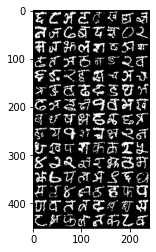

In [76]:
show_adn_save("real",make_grid(v.view(120,1,28,28).data))

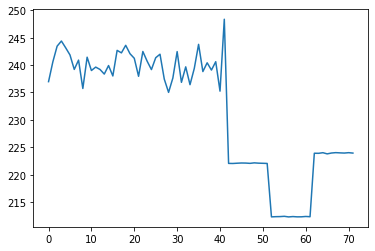

In [77]:
plt.plot(loss_boltzman)

In [78]:
torch.save(rbm.state_dict(), "saved_models/rbm_nepali_characters.pth")